In [1]:
import math
import torch
import torchio
import itkwidgets
import itk
import numpy as np
torch.manual_seed(30101983)
fpg = torchio.datasets.FPG()

[0.2563624978065491, 0.3877963423728943, 0.4114031195640564, -0.26373666524887085, 0.2777278423309326, -0.41562485694885254, -0.054557740688323975, -0.3038540482521057, -0.4525220990180969, 0.19183307886123657, 0.4631372094154358, -0.2166067361831665, 0.03797084093093872, 0.451107382774353, 0.2791316509246826, 0.06944388151168823, -0.10055124759674072, 0.08752375841140747, 0.05593222379684448, -0.0852741003036499]
quality reduction: 2.272374261805078


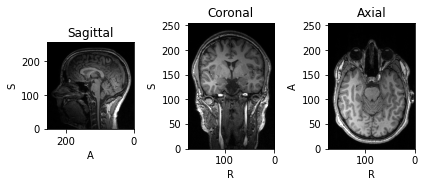

[-0.03306955099105835, -0.19752687215805054, 0.2129991054534912, -0.025288760662078857, 0.4606142044067383, 0.12949925661087036, 0.2453569769859314, -0.3630337119102478, -0.08505016565322876, 0.30447715520858765, -0.31904637813568115, -0.3738914728164673, 0.02310091257095337, -0.2864724397659302, -0.2992362380027771, -0.2075074315071106, 0.3424168825149536, 0.2247077226638794, -0.1700904369354248, -0.3775370121002197]
quality reduction: 2.1844756328048


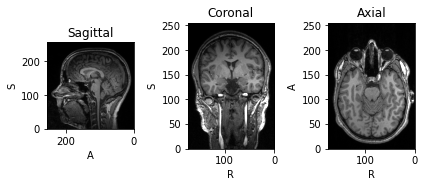

[-0.20992517471313477, -0.060162127017974854, -0.42742669582366943, -0.47475409507751465, -0.23798644542694092, 0.3448490500450134, 0.07255059480667114, -0.30980145931243896, 0.2193002700805664, -0.4271532893180847, -0.3417631983757019, 0.18111252784729004, 0.005743205547332764, 0.2830238342285156, -0.4994814991950989, -0.42469674348831177, -0.05312216281890869, -0.2029958963394165, 0.42663151025772095, 0.18564367294311523]
quality reduction: 2.372304739022974


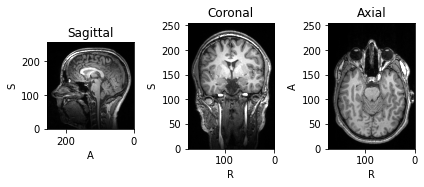

[-0.13626611232757568, 0.48601168394088745, 0.22679615020751953, 0.4716417193412781, 0.3569639325141907, 0.2736496329307556, 0.06474852561950684, 0.051710546016693115, 0.4264605641365051, -0.24619662761688232, -0.17102867364883423, -0.26337260007858276, -0.006802916526794434, 0.20515376329421997, 0.06385606527328491, 0.27910441160202026, 0.13722097873687744, -0.2119375467300415, -0.0066748857498168945, -0.4713670015335083]
quality reduction: 2.220253664239983


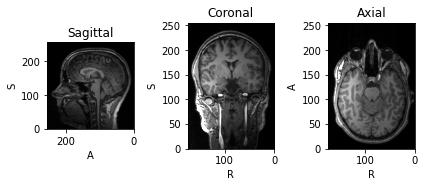

In [2]:
class CustomBiasField(torchio.transforms.RandomBiasField):
    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        transformed_subject = super().apply_transform(subject)

        # now determine how much quality was reduced
        applied_params = transformed_subject.applied_transforms[-1][1]
        coefficients = applied_params['coefficients']['t1']
        quality_reduction = 1 + np.linalg.norm(np.asarray(coefficients))

        print(coefficients)
        print(f"quality reduction: {quality_reduction}")

        return transformed_subject




inhomogeneity = CustomBiasField(p=1, coefficients=(-0.5, 0.5))

inhomogeneity(fpg).t1.plot()
inhomogeneity(fpg).t1.plot()
inhomogeneity(fpg).t1.plot()
inhomogeneity(fpg).t1.plot()

1.2405905723571777
quality reduction: 2.4059057235717773


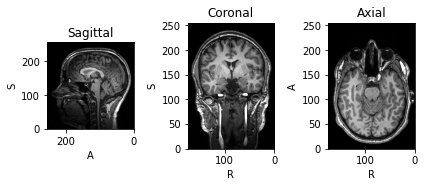

0.9277588129043579
quality reduction: 0.7224118709564209


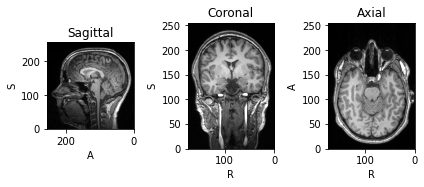

1.2322789430618286
quality reduction: 2.322789430618286


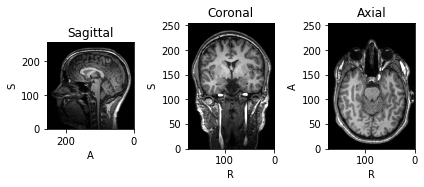

1.0844910144805908
quality reduction: 0.8449101448059082


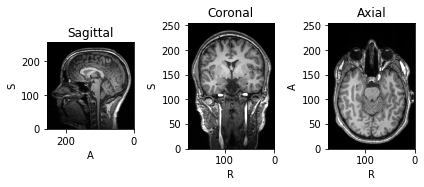

In [3]:
class CustomGamma(torchio.transforms.RandomGamma):
    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        transformed_subject = super().apply_transform(subject)

        # now determine how much quality was reduced
        applied_params = transformed_subject.applied_transforms[-1][1]
        gamma = applied_params['gamma']['t1'][0]
        quality_reduction = 10 * abs(1.0 - gamma)
        
        print(gamma)
        print(f"quality reduction: {quality_reduction}")
        
        return transformed_subject


gamma = CustomGamma()

gamma(fpg).t1.plot()
gamma(fpg).t1.plot()
gamma(fpg).t1.plot()
gamma(fpg).t1.plot()

[[0.33569223 0.22326118 0.54229975]]
quality reduction: 1.2799359560012817


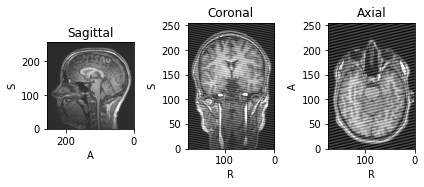

[[0.39436263 0.45337266 0.45630383]]
quality reduction: 2.800182342529297


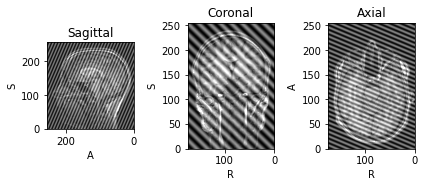

[[0.9919021  0.6974846  0.61761296]]
quality reduction: 1.728411316871643


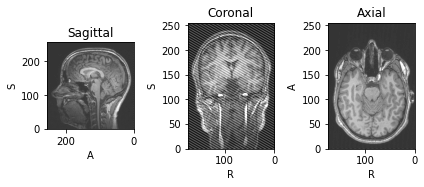

[[0.19371372 0.3353085  0.57747865]]
quality reduction: 2.285545587539673


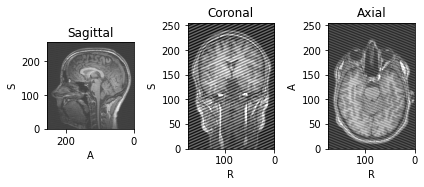

In [4]:
class CustomSpike(torchio.transforms.RandomSpike):
    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        transformed_subject = super().apply_transform(subject)

        # now determine how much quality was reduced
        applied_params = transformed_subject.applied_transforms[-1][1]
        intensity = applied_params['intensity']['t1']
        spikes_positions = applied_params['spikes_positions']['t1']
        quality_reduction = intensity

        print(spikes_positions)
        print(f"quality reduction: {quality_reduction}")
        
        return transformed_subject

spike = CustomSpike(num_spikes=(1,1))

spike(fpg).t1.plot()
spike(fpg).t1.plot()
spike(fpg).t1.plot()
spike(fpg).t1.plot()

180.79910278320312
quality reduction: 7.231964111328125


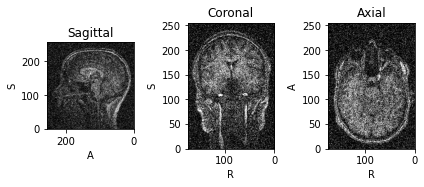

99.04684448242188
quality reduction: 3.961873779296875


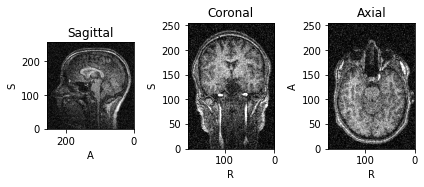

88.98609924316406
quality reduction: 3.5594439697265625


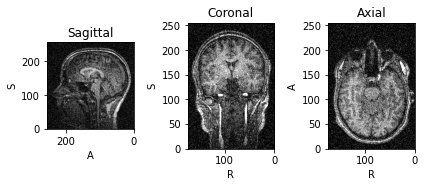

12.009352684020996
quality reduction: 0.48037410736083985


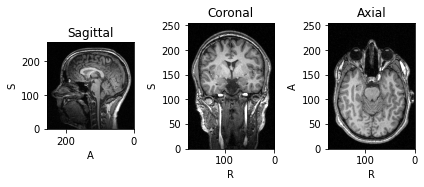

In [8]:
class CustomNoise(torchio.transforms.RandomNoise):
    def apply_transform(self, subject: torchio.Subject) -> torchio.Subject:
        transformed_subject = super().apply_transform(subject)
        transformed_subject.t1.set_data(torch.clamp(transformed_subject.t1.data, min=0.0, max=1000))

        # now determine how much quality was reduced
        applied_params = transformed_subject.applied_transforms[-1][1]
        std = applied_params['std']['t1']
        quality_reduction = 40 * std / 1000.0

        print(std)
        print(f"quality reduction: {quality_reduction}")
        
        return transformed_subject

noise = CustomNoise(std=(0.0, 250))

#orig = itk.image_view_from_array(torch.squeeze(fpg.t1.data)).astype(itk.F)
#nimg = itk.image_view_from_array(torch.squeeze(noise(fpg).t1.data))
#print(orig)
#print(nimg)
#itkwidgets.checkerboard(orig, nimg, pattern=2)

noise(fpg).t1.plot()
noise(fpg).t1.plot()
noise(fpg).t1.plot()
noise(fpg).t1.plot()